In [1]:
# import sys
# sys.path.insert(1,'/media/mhealthra2/Data/rakib/gits/pytorch-summary/torchsummary')

In [2]:
# from torchsummary2 import summary,summary_string

In [4]:
import sys
sys.path.insert(1,'/media/mhealthra2/Data/pytorch-summary/torchsummary/')
# from torchsummary2 import summary as summ
# import torchsummary2
# torchsummary2 = importlib.reload(torchsummary2)
# from torchsummary2 import summary as summ

In [1]:
import HeartCepTorch

In [2]:
import importlib
HeartCepTorch = importlib.reload(HeartCepTorch)
from HeartCepTorch import MFCC_Gen

In [3]:
import torch
from torch.nn.modules import Module
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from math import floor,ceil
import numpy as np, matplotlib.pyplot as plt, pandas as pd, os
def plotf(x):
    plt.plot(x.cpu().detach().numpy())

In [4]:
from HeartCepTorch import MFCC_Gen,Network
net = MFCC_Gen(fs=1000,filters=64)
summary(net.cuda(),(1,2500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
    Conv_Gammatone-1             [-1, 64, 2420]               0
       BatchNorm1d-2             [-1, 64, 2420]             128
            Conv1d-3              [-1, 64, 240]         102,400
       BatchNorm1d-4              [-1, 64, 240]             128
Total params: 102,656
Trainable params: 256
Non-trainable params: 102,400
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 2.60
Params size (MB): 0.39
Estimated Total Size (MB): 3.00
----------------------------------------------------------------


In [9]:
net.gammanorm.weight

Parameter containing:
tensor([0.2942, 0.4477, 0.0732, 0.9217, 0.3468, 0.0076, 0.2901, 0.9435, 0.4003,
        0.3953, 0.6350, 0.9353, 0.0179, 0.4471, 0.5746, 0.5179, 0.7978, 0.1923,
        0.6307, 0.9164, 0.9655, 0.7278, 0.1357, 0.5458, 0.5611, 0.9126, 0.7267,
        0.9368, 0.3520, 0.3688, 0.6212, 0.6769, 0.6337, 0.1502, 0.3063, 0.1997,
        0.3996, 0.7570, 0.3084, 0.4875, 0.1861, 0.3289, 0.7218, 0.5543, 0.7827,
        0.9964, 0.5488, 0.3242, 0.2298, 0.5506, 0.2729, 0.5202, 0.9180, 0.2537,
        0.4071, 0.1857, 0.7153, 0.5873, 0.1983, 0.7179, 0.9352, 0.9387, 0.6006,
        0.5253], device='cuda:0', requires_grad=True)

In [5]:
import importlib,mfcc_models
mfcc_models = importlib.reload(mfcc_models)
from mfcc_models import Network
net = Network(2,0)

In [5]:
summary(net.cuda(),(1,240,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 244, 65]             128
       BatchNorm2d-2          [-1, 16, 244, 65]              48
            Conv2d-3          [-1, 32, 242, 63]           4,672
       BatchNorm2d-4          [-1, 32, 242, 63]              96
         Dropout2d-5          [-1, 32, 242, 63]               0
            Conv2d-6          [-1, 32, 244, 65]           9,280
       BatchNorm2d-7          [-1, 32, 244, 65]              96
         Dropout2d-8          [-1, 32, 244, 65]               0
            Conv2d-9          [-1, 64, 122, 32]          18,560
      BatchNorm2d-10          [-1, 64, 122, 32]             192
        Dropout2d-11          [-1, 64, 122, 32]               0
           Conv2d-12           [-1, 64, 61, 16]          36,992
      BatchNorm2d-13           [-1, 64, 61, 16]             192
        Dropout2d-14           [-1, 64,

In [17]:
net.extractor.conv0.weight.shape

(torch.Size([16, 1, 3, 2]), torch.Size([32, 16, 3, 3]))

In [15]:
class Branch2d(nn.Module):
    def __init__(self,channels=1,dimension=1):
        super(Branch2d,self).__init__()
        self.conv1 = nn.Conv2d(channels,channels,kernel_size=5)
        self.norm1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()
        
        self.conv2 = nn.Conv2d(channels,channels*2,kernel_size=5)
        self.norm2 = nn.BatchNorm2d(channels*2)
        
    def forward(self,x):
        x = self.relu(self.norm1(self.conv1(x)))
        x = self.relu(self.norm2(self.conv2(x)))
        return x

In [26]:
class Net(nn.Module):
    def __init__(self,kernel_size = 81,filters = 26,fs=1000,winlen=0.025,winstep=0.01,dimension=1):
        super(Net,self).__init__()
        
        self.gamma = Conv_Gammatone_coeff(in_channels=1,out_channels=filters ,kernel_size=kernel_size,fsHz=fs)
#         self.gamma = nn.Conv1d(in_channels=1,out_channels=filters ,kernel_size=81,stride=1)
        self.gammanorm = nn.BatchNorm1d(filters)
        self.mfcc = nn.Conv1d(filters,filters,int(winlen*fs),stride=int(winstep*fs),padding=0,bias=False)
        self.normmfcc = nn.BatchNorm1d(filters)
        self.normmfcc2D = nn.BatchNorm2d(1)
        with torch.no_grad():
            self.mfcc.weight = Parameter(torch.stack([torch.eye(filters) for i in range(int(winlen*fs))],dim=2))
        for x in self.mfcc.named_parameters():
            x[1].requires_grad = False
        
#         self.conv22 = nn.Conv2d(1,3,kernel_size=5)
        self.conv22 = Branch2d(1)
        
#         self.pool = nn.MaxPool1d(2)
        self.linear1 = nn.Linear(8352,2)
        self.soft = nn.Softmax(dim=0)
    
    def forward(self,x):
        x = self.gamma(x)
        gamma = x
        x = self.gammanorm(x)
        x = torch.pow(torch.abs(x),2)
        x = self.mfcc(x)
        x = torch.log(x+0.0000000000000001)
#         x = x.unsqueeze(1)
#         x = self.conv22(x)
#         x = x.view(x.size(0), -1)
#         x = self.linear1(x)
#         x = self.soft(x)
        return x,gamma


In [10]:
import scipy.io.wavfile as wav
(fs,sig) = wav.read(os.path.join("..","gammatonegram","gammatonegram","sa2.wav"))

In [28]:
net = Net(fs=fs,filters=64,winlen=0.025,winstep=0.01)
wow = summary(net.cuda(),(1,2500))

NameError: name 'Conv_Gammatone_coeff' is not defined

In [37]:
for x in net.named_parameters():
    print(x[0],x[1].shape)

gamma.weight torch.Size([64, 1, 81])
gammanorm.weight torch.Size([64])
gammanorm.bias torch.Size([64])
mfcc.weight torch.Size([64, 64, 400])
normmfcc.weight torch.Size([64])
normmfcc.bias torch.Size([64])
normmfcc2D.weight torch.Size([1])
normmfcc2D.bias torch.Size([1])
conv22.conv1.weight torch.Size([1, 1, 5, 5])
conv22.conv1.bias torch.Size([1])
conv22.norm1.weight torch.Size([1])
conv22.norm1.bias torch.Size([1])
conv22.conv2.weight torch.Size([2, 1, 5, 5])
conv22.conv2.bias torch.Size([2])
conv22.norm2.weight torch.Size([2])
conv22.norm2.bias torch.Size([2])
linear1.weight torch.Size([2, 8352])
linear1.bias torch.Size([2])


In [11]:
# sig = sig/max(abs(sig))
sig = sig.astype(np.float32)

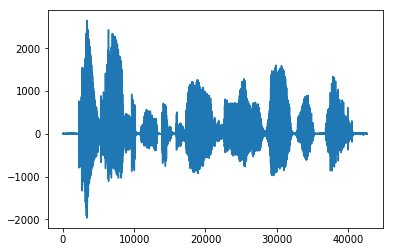

In [12]:
plt.plot(sig)

In [35]:
net.train()
net.eval()
out = net(torch.from_numpy(sig[:5000]).unsqueeze(0).unsqueeze(0).cuda())[0]

In [36]:
wow = (out.squeeze(0).cpu().detach().numpy())

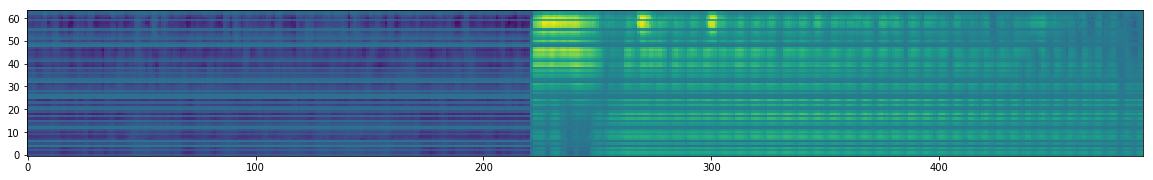

In [37]:
plt.figure(figsize=(20,20))
from matplotlib import cm
plt.imshow((wow), interpolation='nearest', origin='lower')

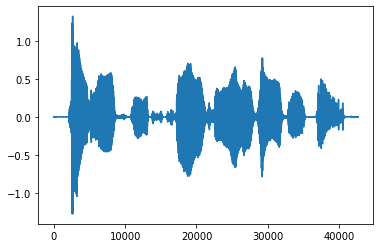

In [49]:
idx = 60
plotf(gamma[0][idx][:])


In [82]:
from __future__ import print_function, division, absolute_import
import sys
def get_env():
    sp = sys.path[1].split("/")
    if "envs" in sp:
        return sp[sp.index("envs") + 1]
    else:
        return ""

# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# set_session(tf.Session(config=config))
# from clr_callback import CyclicLR
# import dill
from BalancedDannAudioDataGenerator import BalancedAudioDataGenerator
import os,time
from scipy.io import loadmat
import numpy as np
np.random.seed(1)
import math
import pandas as pd
import tables,h5py
from datetime import datetime
import argparse
from keras.utils import plot_model
from Heartnet import heartnet,getAttentionModel
from collections import Counter
if("torch" in get_env()):
    from torchviz import make_dot
from utils import log_macc, results_log
from dataLoader import reshape_folds
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
import matplotlib.pyplot as plt
# import seaborn as sns
import Evaluator
import dataLoader
from custom_layers import Attention
from sklearn.model_selection import train_test_split

In [57]:
class wow():
    def __init__(self):
        self.dann = False
        self.self = True
        self.reduce = None
        self.shuffle = 1
        self.mfcc = False
args = wow()
batch_size = 1000

In [58]:
test_domains = 'a'
train_domains = ''
# source_domain = train_domains
# target_domain = test_domains

test_split = 0
fold_dir = '../../feature/potes_1DCNN/balancedCV/folds/all_folds_wav_name/'

domains = set(train_domains + test_domains)
#num_class_domain = len(set(train_domains + test_domains))
num_class_domain = len(domains)
num_class = 2
if(args.self):
    print("Self training activated")
    x_train, y_train, y_domain, train_parts, x_val, y_val, val_domain, val_parts,val_wav_files = dataLoader.getData(fold_dir,'',test_domains,0.75,shuffle=args.shuffle)
    print("Self training wtf")

    print(x_train.shape, x_val.shape)
    print("Self training shapes koi? ")
else:
    x_train, y_train, y_domain, train_parts,x_val, y_val, val_domain, val_parts, val_wav_files = dataLoader.getData(fold_dir,train_domains,test_domains,test_split,shuffle = args.shuffle)

if(args.reduce):
    print("Reduction ", args.reduce)
    x_train,_,y_train,_,y_domain,_ = train_test_split(x_train.transpose(),y_train,y_domain,stratify=y_train,test_size = args.reduce)
    x_train = x_train.transpose()

    #x_val,_,y_val,_,val_domain,_ = train_test_split(x_val.transpose(),y_val,val_domain,stratify=y_val,test_size = args.reduce)
    #x_val = x_val.transpose()

val_files = val_domain
#Create meta labels and domain labels
domains = train_domains
if(test_split>0):
    domains = "".join(set(domains).union(set(test_domains)))
    #domains = domains + test_domains
elif(args.dann):
    domains = "".join(set(domains).union(set(test_domains)))
    #domains = domains + test_domains

if(args.self):
    print("self training")
    domains = test_domains
    num_class_domain = len(set(domains))

domainClass = [(cls,dfc) for cls in range(2) for dfc in domains]

if(args.dann):
    meta_labels = [domainClass.index((cl,df)) for (cl,df) in zip(np.concatenate((y_train,y_val)),(y_domain+val_domain))]
else:
    meta_labels = [domainClass.index((cl,df)) for (cl,df) in zip(y_train,y_domain)]

domains = "".join(set(domains).union(set(test_domains)))

y_domain = np.array([list(domains).index(lab) for lab in y_domain])

val_domain = np.array([list(domains).index(lab) for lab in val_domain])

Self training activated
Train normal -  3217 - 7409  Abnormal
                30  -  69 %
Test normal -  1086 - 2455  Abnormal
               30  -  69 %
Self training wtf
(2500, 10626) (2500, 3541)
Self training shapes koi? 
self training


In [59]:
if(args.dann):
    print("x_val is added to training without labels")
    x_train = np.concatenate((x_train,x_val),axis=1)
    y_domain= np.concatenate((y_domain,val_domain))
[x_train, x_val], [y_train,y_domain,y_val] = reshape_folds([x_train,x_val],[y_train,y_domain,y_val])
y_train = to_categorical(y_train, num_classes=num_class)
if(args.dann):
    y_train = np.concatenate((y_train,np.zeros((y_val.shape[0],2))))
print("Y domain ", Counter([x[0] for x in y_domain]))
print("Val domain ", Counter(val_domain))
print("Meta labels ", Counter(meta_labels))
y_domain = to_categorical(y_domain,num_classes=num_class_domain)
y_val = to_categorical(y_val, num_classes=num_class)
val_domain = to_categorical(val_domain,num_classes=num_class_domain)
print("Train files ", y_train.shape, "  Domain ", y_domain.shape)
print("Test files ", y_val.shape, "  Domain ", val_domain.shape)

### Batch Size limmiter 
if(batch_size > max(y_train.shape)):
    print("Batch size if given greater than train files size. limiting batch size")
    batch_size = max(y_train.shape)

reshaped x  (10626, 2500, 1)
reshaped x  (3541, 2500, 1)
reshaped Y  (10626, 1)
reshaped Y  (10626, 1)
reshaped Y  (3541, 1)
Y domain  Counter({0: 10626})
Val domain  Counter({0: 3541})
Meta labels  Counter({1: 7409, 0: 3217})
Train files  (10626, 2)   Domain  (10626, 1)
Test files  (3541, 2)   Domain  (3541, 1)


In [60]:
######## change 2500 axis for pytorch 
if("torch" in get_env()):
    print("Yeah")
    if(not args.mfcc):
        x_train = x_train.transpose((0,2,1))
        x_val = x_val.transpose((0,2,1))

Yeah


In [ ]:
flow.

In [89]:
datagen = BalancedAudioDataGenerator(shift=.1)
flow = datagen.flow(x_train, y_train,
                meta_label=np.argmax(y_train,axis=1),
                batch_size=batch_size, shuffle=True,
                seed=1)

[3217 7409]
[0 1]
Chunk size selected as 500


/media/mhealthra2/Data/heart_sound/Adversarial-Heart-Sound-Classification/codes/BalancedDannAudioDataGenerator.py:841: UserWarning: `meta_labels` specified, will use meta_labels instead of target_label
  warnings.warn('`meta_labels` specified, will use meta_labels instead of target_label')
/media/mhealthra2/Data/heart_sound/Adversarial-Heart-Sound-Classification/codes/BalancedDannAudioDataGenerator.py:657: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 2), i.e. expected either 1, 3 or 4 channels on axis 2. However, it was passed an array with shape (10626, 1, 2500) (2500 channels).
  self.x.shape) + ' (' + str(self.x.shape[channels_axis]) + ' channels).')


In [4]:
import torch.optim as optim
import torch
from torch.autograd import Variable
import time
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchsummary import summary
# from CSVLogger import CSVLogger

In [3]:
mfcc_models

['/media/mhealthra2/Data/heart_sound/Adversarial-Heart-Sound-Classification/codes',
 '/home/mhealthra2/anaconda3/envs/torch/lib/python37.zip',
 '/home/mhealthra2/anaconda3/envs/torch/lib/python3.7',
 '/home/mhealthra2/anaconda3/envs/torch/lib/python3.7/lib-dynload',
 '',
 '/home/mhealthra2/anaconda3/envs/torch/lib/python3.7/site-packages',
 '/home/mhealthra2/anaconda3/envs/torch/lib/python3.7/site-packages/IPython/extensions',
 '/home/mhealthra2/.ipython',
 '/lib/python3.7/site-packages']

In [2]:
import sys
print(sys.path)
sys.path.append('/lib/python3.7/site-packages')
from PIL import Image

['/media/mhealthra2/Data/heart_sound/Adversarial-Heart-Sound-Classification/codes', '/home/mhealthra2/anaconda3/envs/torch/lib/python37.zip', '/home/mhealthra2/anaconda3/envs/torch/lib/python3.7', '/home/mhealthra2/anaconda3/envs/torch/lib/python3.7/lib-dynload', '', '/home/mhealthra2/anaconda3/envs/torch/lib/python3.7/site-packages', '/home/mhealthra2/anaconda3/envs/torch/lib/python3.7/site-packages/IPython/extensions', '/home/mhealthra2/.ipython']


In [96]:
optimizer = optim.Adam(net.parameters(), lr= .001)
class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.CrossEntropyLoss()

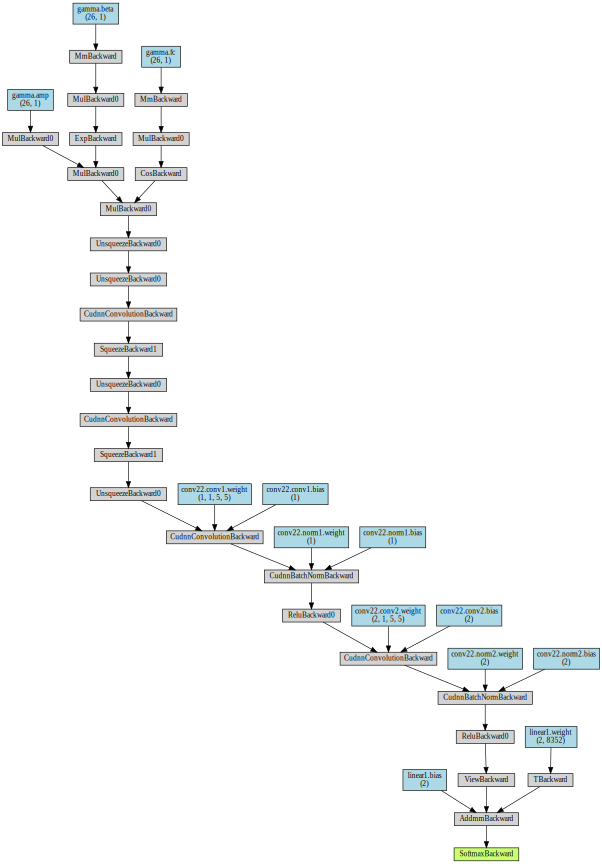

In [97]:
out = net(torch.randn(1,1,2500).cuda())
make_dot(out,params = dict(net.named_parameters()))

In [101]:
net.cuda()
epochs = 10

print("steps ", flow.steps_per_epoch)


for e in range(epochs):
    print("EPOCH   ",e+1)
    net.train()
    epoch_loss = 0
    epoch_class_loss = 0
    epoch_domain_loss = 0
    cls_pred = None
    dom_pred = None
    y_label = None
    
    for i in range(flow.steps_per_epoch+1):
        
        optimizer.zero_grad()
        
        x,y = flow.next()
        x,y = torch.from_numpy(x),torch.from_numpy(y)
        x,y = Variable(x),Variable(y)
        x = x.type(torch.FloatTensor).cuda()
        y = y.long().cuda()
        cls = net(x)
        class_loss = class_criterion(cls,torch.argmax(y,axis=1)).type(torch.FloatTensor)
        
        loss = class_loss
        epoch_loss = epoch_loss + loss
        
        loss.backward()
        optimizer.step()

    epoch_loss = epoch_loss/flow.steps_per_epoch
    
    
    print("Training loss fo", "%.2f"%(epoch_loss.item()/flow.steps_per_epoch),end=' ')
    # Validate 
    net.eval()
    with torch.no_grad():
        cls_pred = None
        dom_pred = None
        epoch_val_loss = 0
        epoch_val_class_loss = 0
        epoch_val_domain_loss = 0
        s = 0
        for part in val_parts:
            x,y = torch.from_numpy(x_val[s:s+part]),torch.from_numpy(y_val[s:s+part])
            s = s + part
            x,y = Variable(x),Variable(y)
            x = x.type(torch.FloatTensor).cuda()
            if(args.mfcc):
                x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
            y = y.long().cuda()
            
            #print("hwat",x.shape)
            cls = net(x)
            if(cls_pred is None):
                cls_pred = cls
            else:
                cls_pred = torch.cat((cls_pred,cls),axis=0)
            val_class_loss = class_criterion(cls,torch.argmax(y,axis=1))
            epoch_val_class_loss = epoch_val_class_loss + val_class_loss
        epoch_val_class_loss = epoch_val_class_loss/len(val_parts)
        print("val_Class_loss  ","%.2f"%epoch_val_class_loss.item())

    
    
    flow.reset()

steps  14
EPOCH    1
Training loss fo 0.05 val_Class_loss   0.69
EPOCH    2
Training loss fo 0.05 val_Class_loss   0.69
EPOCH    3
Training loss fo 0.05 val_Class_loss   0.69
EPOCH    4
Training loss fo 0.05 val_Class_loss   0.69
EPOCH    5
Training loss fo 0.05 val_Class_loss   0.69
EPOCH    6
Training loss fo 0.05 val_Class_loss   0.69
EPOCH    7
Training loss fo 0.05 val_Class_loss   0.69
EPOCH    8
Training loss fo 0.05 val_Class_loss   0.69
EPOCH    9
Training loss fo 0.05 val_Class_loss   0.69
EPOCH    10
Training loss fo 0.05 val_Class_loss   0.69


In [102]:
net.mfcc

AttributeError: 'Branch2d' object has no attribute 'out'

In [12]:
import torch
import torch.nn as nn
from torch.autograd import Variable

from collections import OrderedDict
import numpy as np

def register_hook(module):

    def hook(module, input, output):
        class_name = str(module.__class__).split(".")[-1].split("'")[0]
        module_idx = len(summary)
        
        
        m_key = "%s-%i" % (class_name, module_idx + 1)
        summary[m_key] = OrderedDict()
        summary[m_key]["input_shape"] = list(input[0].size())
        summary[m_key]["input_shape"][0] = batch_size
        if isinstance(output, (list, tuple)):
            summary[m_key]["output_shape"] = [
                [-1] + list(o.size())[1:] for o in output
            ]
        else:
            summary[m_key]["output_shape"] = list(output.size())
            summary[m_key]["output_shape"][0] = batch_size

        params = 0
        
        ### updated part
        for (name,weight) in module.named_parameters():
            params += torch.prod(torch.LongTensor(list(weight.shape)))
            summary[m_key]["trainable"] = weight.requires_grad
        ###
           
        ### previously was this
#         if hasattr(module, "weight") and hasattr(module.weight, "size"):
#             params += torch.prod(torch.LongTensor(list(module.weight.size())))
#             summary[m_key]["trainable"] = module.weight.requires_grad
        ###
    
    
        if hasattr(module, "bias") and hasattr(module.bias, "size"):
            params += torch.prod(torch.LongTensor(list(module.bias.size())))
        summary[m_key]["nb_params"] = params

    if (
        not isinstance(module, nn.Sequential)
        and not isinstance(module, nn.ModuleList)
        and not (module == model)
    ):
        hooks.append(module.register_forward_hook(hook))

In [13]:
device="cuda"
if device == "cuda" and torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

In [14]:
input_size = (1,2500)
if isinstance(input_size, tuple):
    input_size = [input_size]
x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]

In [15]:
summary = OrderedDict()
hooks = []

In [16]:
summary,hooks

(OrderedDict(), [])

In [17]:
model = net.cuda()
model.apply(register_hook)

Net(
  (conv1): Conv_Gammatone(1, 64, kernel_size=(81,), stride=(1,), bias=False)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (soft): Softmax(dim=0)
)

In [18]:
batch_size = 2
model(*x)

In [19]:
for h in hooks:
    h.remove()

In [20]:
print("----------------------------------------------------------------")
line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
print(line_new)
print("================================================================")
total_params = 0
total_output = 0
trainable_params = 0

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #


In [21]:
for layer in summary:
    print(layer)
    print()

Conv_Gammatone-1

MaxPool1d-2

Softmax-3



In [22]:
for layer in summary:
    print(layer)
    print(summary[layer]["nb_params"])
    # input_shape, output_shape, trainable, nb_params
    line_new = "{:>20}  {:>25} {:>15}".format(
        layer,
        str(summary[layer]["output_shape"]),
        "{0:,}".format(summary[layer]["nb_params"]),
    )
    total_params += summary[layer]["nb_params"]
    total_output += np.prod(summary[layer]["output_shape"])
    if "trainable" in summary[layer]:
        if summary[layer]["trainable"] == True:
            trainable_params += summary[layer]["nb_params"]
    print(line_new)

Conv_Gammatone-1
tensor(192)
    Conv_Gammatone-1              [2, 64, 2420]             192
MaxPool1d-2
0
         MaxPool1d-2              [2, 64, 1210]               0
Softmax-3
0
           Softmax-3              [2, 64, 1210]               0


In [24]:
total_params.numpy()

array(192)

In [243]:
Parameter(torch.Tensor(in_channels, out_channels // groups, *kernel_size))
Parameter(torch.Tensor(1, filters, kernel_size))

NameError: name 'in_channels' is not defined

In [29]:
def hz2mel(hz):
        return 2595 * np.log10(1+hz/700.)
def mel2hz(mel):
    return 700*(10**(mel/2595.0)-1)

In [200]:
Parameter(torch.ones((5,1))*20)

Parameter containing:
tensor([[20.],
        [20.],
        [20.],
        [20.],
        [20.]], requires_grad=True)

In [21]:
from torch.nn.parameter import Parameter
from torch.nn.modules.utils import _single
class Conv_Gammatone(Module):

    __constants__ = ['stride', 'padding', 'dilation', 'groups', 'bias',
                     'padding_mode', 'output_padding', 'in_channels',
                     'out_channels', 'kernel_size']

    def __init__(self, in_channels, out_channels, kernel_size,fsHz, stride=1,
                 padding=0, dilation=1, transposed=False, output_padding=(0,),
                 groups=1, bias=False, padding_mode='zeros',fc=None,
                 beta_val=100,amp_val=10**4,n_order=4):
        super(Conv_Gammatone, self).__init__()
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.filters = out_channels
        self.kernel_size = _single(kernel_size)
        self.stride = _single(stride)
        self.padding = _single(padding)
        self.dilation = _single(dilation)
        self.transposed = transposed
        self.output_padding = output_padding
        self.groups = groups
        self.padding_mode = padding_mode
        self.fsHz = fsHz
        if(fc is not None):
            if isinstance(fc,tuple):
                (minf,maxf)=fc
            else:
                minf = 0
                maxf = fc
        else:
            minf = 0
            maxf = self.fsHz/2
        self.fc = Parameter(torch.from_numpy(self.mel2hz(np.linspace(self.hz2mel(minf),self.hz2mel(maxf),
                            self.filters,dtype=np.float32))).unsqueeze(-1))
        
        self.beta = Parameter(torch.ones((self.filters,1))*beta_val)
        
        self.amp = Parameter(torch.ones((self.filters,1))*amp_val)
        
        self.n_order = (torch.tensor(n_order,dtype=torch.float))
        
#         self.weight = torch.([self.fc, self.beta, self.amp])
        
        self.register_parameter('bias', None)
    def impulse_gammatone(self):
        device = 0
#         print(self.amp.get_device())
#         print(self.beta.get_device())
#         print(self.fc.get_device())
#         print(self.n_order.get_device())
        
        self.t = torch.arange(0,self.kernel_size[0]/self.fsHz,
                            1/self.fsHz,dtype = torch.float32).unsqueeze(-1).transpose(1,0)
    
        self.t = self.t.type(torch.FloatTensor)
        self.n_order = self.n_order.type(torch.FloatTensor)
#         print("device",self.t.get_device())
#         print(self.n_order.get_device())
#         print(self.amp.get_device())
        power = torch.pow(self.t,self.n_order-1)
#         print("power ", power.get_device())
        power = power.to(device = device)
#         print("power ", power.get_device())
        
        at = self.amp.to(device=device)*power
        
#         print("exp")
#         print((-2*torch.tensor(np.pi).to(device)).get_device())
#         print(":/ "torch.mm(self.beta,self.t.to(device)).get_device())
        
        exp = torch.exp(-2*torch.tensor(np.pi).to(device)*torch.mm(self.beta.to(device),self.t.to(device)))
        cos = torch.cos(2*torch.tensor(np.pi).to(device)*torch.mm(self.fc.to(device),self.t.to(device)))
        return at*exp*cos
    def forward(self, input):
        gammatone = self.impulse_gammatone().unsqueeze(1)
#         if self.padding_mode == 'circular':
#             expanded_padding = ((self.padding[0] + 1) // 2, self.padding[0] // 2)
#             return F.conv1d(F.pad(input, expanded_padding, mode='circular'),
#                             gammatone, self.bias, self.stride,
#                             _single(0), self.dilation, self.groups)
        return F.conv1d(input, gammatone, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)
    
    
#     def reset_parameters(self):
#         init.kaiming_uniform_(self.weight, a=math.sqrt(5))
#         if self.bias is not None:
#             fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
#             bound = 1 / math.sqrt(fan_in)
#             init.uniform_(self.bias, -bound, bound)
    def hz2mel(self,hz):
        return 2595 * np.log10(1+hz/700.)
    def mel2hz(self,mel):
        return 700*(10**(mel/2595.0)-1)
    def extra_repr(self):
        s = ('{in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1,) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.output_padding != (0,) * len(self.output_padding):
            s += ', output_padding={output_padding}'
        if self.groups != 1:
            s += ', groups={groups}'
        if self.bias is None:
            s += ', bias=False'
        return s.format(**self.__dict__)

    def __setstate__(self, state):
        super(Conv_Gammatone, self).__setstate__(state)
        if not hasattr(self, 'padding_mode'):
            self.padding_mode = 'zeros'

In [9]:
from torch.nn.parameter import Parameter
from torch.nn.modules.utils import _single
class Conv_Gammatone_coeff(Module):

    __constants__ = ['stride', 'padding', 'dilation', 'groups', 'bias',
                     'padding_mode', 'output_padding', 'in_channels',
                     'out_channels', 'kernel_size']

    def __init__(self, in_channels, out_channels, kernel_size,fsHz, stride=1,
                 padding=0, dilation=1, transposed=False, output_padding=(0,),
                 groups=1, bias=False, padding_mode='zeros',fc=None,
                 beta_val=100,amp_val=10**4,n_order=4):
        super(Conv_Gammatone_coeff, self).__init__()
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.filters = out_channels
        self.kernel_size = _single(kernel_size)
        self.stride = _single(stride)
        self.padding = _single(padding)
        self.dilation = _single(dilation)
        self.transposed = transposed
        self.output_padding = output_padding
        self.groups = groups
        self.padding_mode = padding_mode
        self.fsHz = fsHz
        if(fc is not None):
            if isinstance(fc,tuple):
                (minf,maxf)=fc
            else:
                minf = 0
                maxf = fc
        else:
            minf = 0
            maxf = self.fsHz/2
        self.fc = (torch.from_numpy(self.mel2hz(np.linspace(self.hz2mel(minf),self.hz2mel(maxf),
                            self.filters,dtype=np.float32))).unsqueeze(-1))
        
        self.beta = (torch.ones((self.filters,1))*beta_val)
        
        self.amp = (torch.ones((self.filters,1))*amp_val)
        
        self.n_order = (torch.tensor(n_order,dtype=torch.float))
        
        self.weight = Parameter(self.impulse_gammatone().unsqueeze(1))
        
        self.register_parameter('bias', None)
    def impulse_gammatone(self):
        device = 0
#         print(self.amp.get_device())
#         print(self.beta.get_device())
#         print(self.fc.get_device())
#         print(self.n_order.get_device())
        
        self.t = torch.arange(0,self.kernel_size[0]/self.fsHz,
                            1/self.fsHz,dtype = torch.float32).unsqueeze(-1).transpose(1,0)
    
        self.t = self.t.type(torch.FloatTensor)
        self.n_order = self.n_order.type(torch.FloatTensor)
#         print("device",self.t.get_device())
#         print(self.n_order.get_device())
#         print(self.amp.get_device())
        power = torch.pow(self.t,self.n_order-1)
#         print("power ", power.get_device())
        power = power.to(device = device)
#         print("power ", power.get_device())
        
        at = self.amp.to(device=device)*power
        
#         print("exp")
#         print((-2*torch.tensor(np.pi).to(device)).get_device())
#         print(":/ "torch.mm(self.beta,self.t.to(device)).get_device())
        
        exp = torch.exp(-2*torch.tensor(np.pi).to(device)*torch.mm(self.beta.to(device),self.t.to(device)))
        cos = torch.cos(2*torch.tensor(np.pi).to(device)*torch.mm(self.fc.to(device),self.t.to(device)))
        return at*exp*cos
    def forward(self, input):
#         gammatone = self.impulse_gammatone().unsqueeze(1)
#         if self.padding_mode == 'circular':
#             expanded_padding = ((self.padding[0] + 1) // 2, self.padding[0] // 2)
#             return F.conv1d(F.pad(input, expanded_padding, mode='circular'),
#                             gammatone, self.bias, self.stride,
#                             _single(0), self.dilation, self.groups)
        return F.conv1d(input, self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)
    
    
#     def reset_parameters(self):
#         init.kaiming_uniform_(self.weight, a=math.sqrt(5))
#         if self.bias is not None:
#             fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
#             bound = 1 / math.sqrt(fan_in)
#             init.uniform_(self.bias, -bound, bound)
    def hz2mel(self,hz):
        return 2595 * np.log10(1+hz/700.)
    def mel2hz(self,mel):
        return 700*(10**(mel/2595.0)-1)
    def extra_repr(self):
        s = ('{in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1,) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.output_padding != (0,) * len(self.output_padding):
            s += ', output_padding={output_padding}'
        if self.groups != 1:
            s += ', groups={groups}'
        if self.bias is None:
            s += ', bias=False'
        return s.format(**self.__dict__)

    def __setstate__(self, state):
        super(Conv_Gammatone, self).__setstate__(state)
        if not hasattr(self, 'padding_mode'):
            self.padding_mode = 'zeros'

In [ ]:
from torch.nn.parameter import Parameter
from torch.nn.modules.utils import _single
class Conv_Gammatone_coeff_3d(Module):

    __constants__ = ['stride', 'padding', 'dilation', 'groups', 'bias',
                     'padding_mode', 'output_padding', 'in_channels',
                     'out_channels', 'kernel_size']

    def __init__(self, in_channels, out_channels, kernel_size,fsHz, stride=1,
                 padding=0, dilation=1, transposed=False, output_padding=(0,),
                 groups=1, bias=False, padding_mode='zeros',fc=None,
                 beta_val=100,amp_val=10**4,n_order=4):
        super(Conv_Gammatone_coeff, self).__init__()
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.filters = out_channels
        self.kernel_size = _single(kernel_size)
        self.stride = _single(stride)
        self.padding = _single(padding)
        self.dilation = _single(dilation)
        self.transposed = transposed
        self.output_padding = output_padding
        self.groups = groups
        self.padding_mode = padding_mode
        self.fsHz = fsHz
        if(fc is not None):
            if isinstance(fc,tuple):
                (minf,maxf)=fc
            else:
                minf = 0
                maxf = fc
        else:
            minf = 0
            maxf = self.fsHz/2
        self.fc = (torch.from_numpy(self.mel2hz(np.linspace(self.hz2mel(minf),self.hz2mel(maxf),
                            self.filters,dtype=np.float32))).unsqueeze(-1))
        
        self.beta = (torch.ones((self.filters,1))*beta_val)
        
        self.amp = (torch.ones((self.filters,1))*amp_val)
        
        self.n_order = (torch.tensor(n_order,dtype=torch.float))
        
        self.weight = Parameter(self.impulse_gammatone().unsqueeze(1))
        
        self.register_parameter('bias', None)
    def impulse_gammatone(self):
        device = 0
#         print(self.amp.get_device())
#         print(self.beta.get_device())
#         print(self.fc.get_device())
#         print(self.n_order.get_device())
        
        self.t = torch.arange(0,self.kernel_size[0]/self.fsHz,
                            1/self.fsHz,dtype = torch.float32).unsqueeze(-1).transpose(1,0)
    
        self.t = self.t.type(torch.FloatTensor)
        self.n_order = self.n_order.type(torch.FloatTensor)
#         print("device",self.t.get_device())
#         print(self.n_order.get_device())
#         print(self.amp.get_device())
        power = torch.pow(self.t,self.n_order-1)
#         print("power ", power.get_device())
        power = power.to(device = device)
#         print("power ", power.get_device())
        
        at = self.amp.to(device=device)*power
        
#         print("exp")
#         print((-2*torch.tensor(np.pi).to(device)).get_device())
#         print(":/ "torch.mm(self.beta,self.t.to(device)).get_device())
        
        exp = torch.exp(-2*torch.tensor(np.pi).to(device)*torch.mm(self.beta.to(device),self.t.to(device)))
        cos = torch.cos(2*torch.tensor(np.pi).to(device)*torch.mm(self.fc.to(device),self.t.to(device)))
        return at*exp*cos
    def forward(self, input):
#         gammatone = self.impulse_gammatone().unsqueeze(1)
#         if self.padding_mode == 'circular':
#             expanded_padding = ((self.padding[0] + 1) // 2, self.padding[0] // 2)
#             return F.conv1d(F.pad(input, expanded_padding, mode='circular'),
#                             gammatone, self.bias, self.stride,
#                             _single(0), self.dilation, self.groups)
        return F.conv1d(input, self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)
    
    
#     def reset_parameters(self):
#         init.kaiming_uniform_(self.weight, a=math.sqrt(5))
#         if self.bias is not None:
#             fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
#             bound = 1 / math.sqrt(fan_in)
#             init.uniform_(self.bias, -bound, bound)
    def hz2mel(self,hz):
        return 2595 * np.log10(1+hz/700.)
    def mel2hz(self,mel):
        return 700*(10**(mel/2595.0)-1)
    def extra_repr(self):
        s = ('{in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1,) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.output_padding != (0,) * len(self.output_padding):
            s += ', output_padding={output_padding}'
        if self.groups != 1:
            s += ', groups={groups}'
        if self.bias is None:
            s += ', bias=False'
        return s.format(**self.__dict__)

    def __setstate__(self, state):
        super(Conv_Gammatone, self).__setstate__(state)
        if not hasattr(self, 'padding_mode'):
            self.padding_mode = 'zeros'

In [9]:
def hz2mel(hz):
    return 2595 * np.log10(1+hz/700.)
def mel2hz(mel):
    return 700*(10**(mel/2595.0)-1)

In [180]:
fsHz = 16000
n_order = torch.tensor(4)
minf=0
maxf=500
filters = 64
kernel_size = (81,)
fc = (torch.from_numpy(mel2hz(np.linspace(hz2mel(minf),hz2mel(maxf),
                            filters,dtype=np.float32))).unsqueeze(-1))
device = 0
beta = (torch.ones((filters,1))*100)

amp = (torch.ones((filters,1))*100000)

In [181]:
fsHz

16000

In [182]:
t = torch.arange(0,kernel_size[0]/fsHz,
                            1/fsHz,dtype = torch.float).unsqueeze(-1).transpose(1,0)
    
t = t.type(torch.FloatTensor)
n_order = n_order.type(torch.FloatTensor)
#         print("device",t.get_device())
#         print(n_order.get_device())
#         print(amp.get_device())
power = torch.pow(t,n_order-1)
#         print("power ", power.get_device())
power = power.to(device = device)
#         print("power ", power.get_device())

at = amp.to(device=device)*power

#         print("exp")
#         print((-2*torch.tensor(np.pi).to(device)).get_device())
#         print(":/ "torch.mm(beta,t.to(device)).get_device())

exp = torch.exp(-2*torch.tensor(np.pi).to(device)*torch.mm(beta.to(device),t.to(device)))
cos = torch.cos(2*torch.tensor(np.pi).to(device)*torch.mm(fc.to(device),t.to(device)))
# return at*exp*cos

In [238]:
mm = torch.matmul(fc.to(device),t.to(device))

In [240]:
mm

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 3.7591e-04, 7.5182e-04,  ..., 2.9321e-02, 2.9697e-02,
         3.0073e-02],
        [0.0000e+00, 7.5505e-04, 1.5101e-03,  ..., 5.8894e-02, 5.9649e-02,
         6.0404e-02],
        ...,
        [0.0000e+00, 2.9978e-02, 5.9955e-02,  ..., 2.3383e+00, 2.3682e+00,
         2.3982e+00],
        [0.0000e+00, 3.0611e-02, 6.1222e-02,  ..., 2.3877e+00, 2.4183e+00,
         2.4489e+00],
        [0.0000e+00, 3.1250e-02, 6.2500e-02,  ..., 2.4375e+00, 2.4688e+00,
         2.5000e+00]], device='cuda:0')